# Estimating the counts of seals from citizen scientist tags for the entire Antarct continent
The code below calculates the estimated number of seals counted by citizen scientists, using the methods published in the paper “How many seals do you see? A method for correcting error and increasing reliability of Weddell seal numbers from citizen scientist counts of satellite images”, by L. Salas, M. LaRue, N. Nur, D.G. Ainley, S.E. Stammerjohn, J. Pennycook, J. Rotella, J.T. Paterson, K. Stamatiou, M. Dozier, J. Saints, and L. Barrington (submitted to Methds in Ecology and Evolution). Because some of the tagging campaigns were not very thorough, an enhancement to the calculation is used, and described in [this](https://docs.google.com/document/d/1q8ihZWXapZW8qtxUmmqdYD1gPEMlglG5nez8BBXPG7Q/edit?usp=sharing) document. 

## Preliminary dependencies: libraries and functions

In [126]:
libs<-c("ggplot2","plyr","dplyr","fitdistrplus")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"/home/ubuntu/Workspace/ContinentalWESEestimates/"

######################  FUNCTIONS WE'LL NEED
source(paste0(pathToLocalGit,"scripts/countSealsFromTags_functions.R"))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

### Loading and preparing the data to calculate the estimates

In [127]:
## The taggerId of the expert:
mid<-21758509	## This is Michelle LaRue's tagger Id

## load the data
load(paste0(pathToLocalGit,"data/compiledData.RData"))


##############################
#prepare tag data for the count
tags<-unique(tags)
tgvutm<-merge(tags,views[,c("mapViewId","mapId","region")],by=c("mapViewId","region"),all.x=T)
tgvutm$numTags<-1
tgvutm$regionMapId<-paste0(tgvutm$region,tgvutm$mapId)

#prepare the feature data - for original approach
crt<-merge(crowd[,c("tagId","score","agremnt","sensor","region")],tgvutm[,c("tagId","mapViewId","easting","northing","region","regionTagId","regionMapViewId","regionTaggerId")],by=c("tagId","region"),all.x=T)
crt<-subset(crt,!is.na(mapViewId))
crtm<-merge(crt,views[,c("mapViewId","mapId","region")],by=c("mapViewId","region"),all.x=T)
crtm<-subset(crtm,!is.na(mapId))
crtm$numFeatures<-1
crtm$regionMapId<-paste0(crtm$region,crtm$mapId)

#prepare the tagger crowdrank data
rankdata<-taggers[,c("taggerId","taggerScore","region","regionTaggerId")]

#prepare the expert data
mlCounts<-aggregate(numTags~mapId+region+regionMapId,data=subset(tgvutm,taggerId==mid),FUN=sum)
names(mlCounts)<-c("mapId","region","regionMapId","mlcount")
mlMaps<-unique(subset(views,taggerId==mid))
mlMaps$regionMapId<-paste0(mlMaps$region,mlMaps$mapId)
tagsML<-subset(tgvutm,taggerId==mid)

#Subset the data to only those taggers that overlapped with the expert - find vews, maps, etc.
taggersSel<-unique(subset(views,regionMapId %in% mlMaps$regionMapId,select=c("taggerId","region","regionMapId","regionMapViewId","regionTaggerId")))
taggersSel<-subset(taggersSel,taggerId!=mid)		#taggers who share maps with ML
tagsSel<-subset(tgvutm,regionTaggerId %in% taggersSel$regionTaggerId) 
viewsSel<-subset(views,regionTaggerId %in% c(unique(taggersSel$regionTaggerId),mid))  

##Adding more stringent tagger quality filters
subtaggers<-subset(taggers,taggerScore>0.5 & numApprovedTags > 0)
subtaggers<-subset(subtaggers,regionTaggerId %in% taggersSel$regionTaggerId)   

## Estimate (aporx.) the probability of a feature being found on a map and the probability of a tag being placed on a map
totalMapsInspected<-NROW(unique(views$regionMapId))
totalMapsWtags<-NROW(unique(tgvutm$regionMapId))
totalMapsWfeat<-NROW(unique(crtm$regionMapId))
probFeatInMap<-totalMapsWfeat/totalMapsInspected
probTagInMap<-totalMapsWtags/totalMapsInspected
probTagAsFeat<-totalMapsWfeat/totalMapsWtags


############ Approximating ProbF and ProbS
## ProbF as the probability of placing a tag on a map: num maps with tags/ total num maps inspected
estProbF<-NROW(unique(tgvutm$regionMapId))/NROW(unique(maps$regionMapId))
## ProbS as the probability of ML finding a seal on a map
estProbS<-NROW(unique(tagsML$regionMapId))/NROW(unique(mlMaps$regionMapId))

(estCorr<-estProbS/estProbF)


[1] 0.7579925

### Shrinking the estimates
In our original approach we assume a universal ProbS (see link to document above), and a tagger ProbT that is invariant for the tagger regardless of the map inspected. In this original approach, ProbF is the prob that any tag is found on a map. So, we define it as: ProbF (for each tagger separately) = number of  tags in maps inspected/total number of maps inspected. We know these two assumptions may not hold.

Here we estimate both the original correction factor (option 1) and the new Q correction coefficient (option 2). For these two approaches, we explore using estimates from each tagger that are region-specific (option 1A or 2A), or general for each tagger regardless of region (options 1B and 2B) 


In [128]:
## Version 1A: region-specific corrFactor estimates for each tagger
gspm<-getTaggerProbabilities_tagsOnlybyTag(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,viewsSel=viewsSel,ProbS=estProbS)

## Version 1B: single corrFactor estimate for each tagger
gspmG<-getTaggerProbabilities_tagsOnlybyTag_general(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,viewsSel=viewsSel,ProbS=estProbS)

## Option 2 - use Q: the correction coefficient (see link to document above)
## Version 2A: region-specific Qval estimates for each tagger
gspmQ<-getTaggerProbabilities_fromQ(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,mapsML=mlMaps,viewsSel=viewsSel)

## Version 2B: single Qval estimate for each tagger
gspmQG<-getTaggerProbabilities_fromQ_general(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,mapsML=mlMaps,viewsSel=viewsSel)

############################################################################
## Review the fits and estimates for the correction factors
## Option 1:
print("Option 1A: correction factor from region-specific estimates")
summary(gspm$corrFactor); print(paste("N:",nrow(gspm)))
print("")
print("Option 1B: correction factor from general estimates")
summary(gspmG$corrFactor); print(paste("N:",nrow(gspmG)))
print("")
############################################################################
## Review the fits and estimates for Qvals
## Option 2:
print("Option 2A: Q correction coefficients from region-specific estimates")
summary(gspmQ$Qval); print(paste("N:",nrow(gspmQ)))
print("")
print("Option 2B: Q correction coefficients from region-specific estimates")
summary(gspmQG$Qval); print(paste("N:",nrow(gspmQG)))


[1] "Option 1A: correction factor from region-specific estimates"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.008668 0.158677 0.355401 0.596114 0.689695 4.852705 

[1] "N: 123"
[1] ""
[1] "Option 1B: correction factor from general estimates"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.008668 0.164569 0.327201 0.597943 0.705651 4.852705 

[1] "N: 90"
[1] ""
[1] "Option 2A: Q correction coefficients from region-specific estimates"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01379 0.25753 0.46194 0.56030 0.78732 1.84314 

[1] "N: 130"
[1] ""
[1] "Option 2B: Q correction coefficients from region-specific estimates"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01124 0.25641 0.50804 0.59681 0.86364 2.02941 

[1] "N: 97"


### Review of results - fit probability density functions to the distribution of values
Here we review the results in more detail and fit PDFs to the data. We then decide on the most appropriate estimates to use, and the best PDF to use. 

#### Option 1: The correction factors
Though the region-specific and general estimates of the correction factor are equally dispersed, it is safe to assume that we should use the region-specific values because these are more numerous.

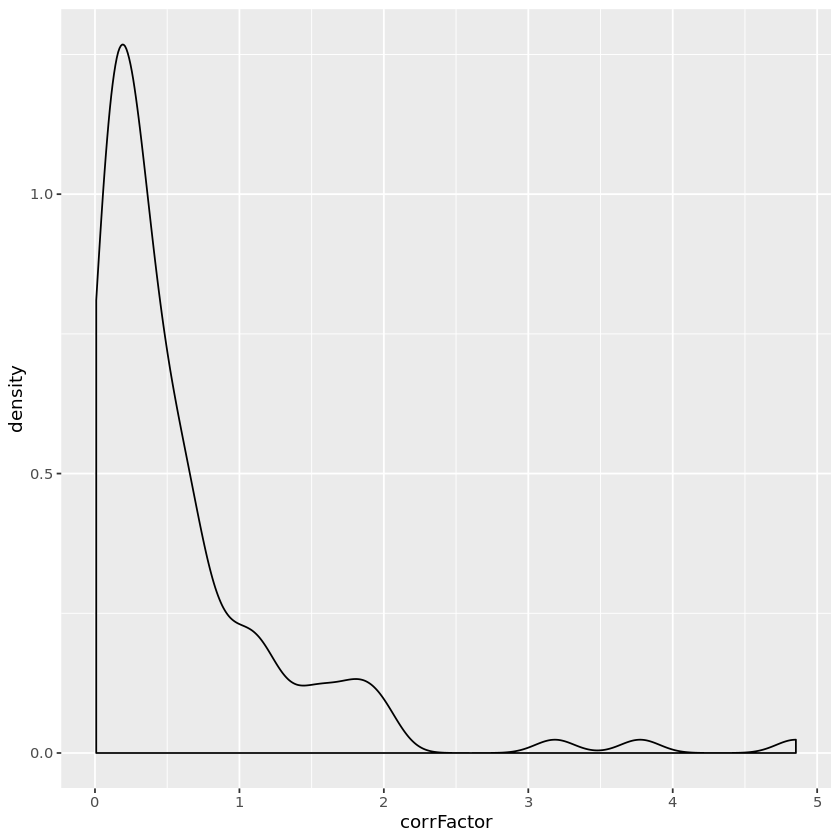

In [129]:
## Checking the distribution of these values
ggplot(gspm,aes(x=corrFactor)) + geom_density()

The above plot shows that it is safe to remove factors of value > 3.5%. There are only 3 of these. 

[1] "Log-normal distribution fit:"


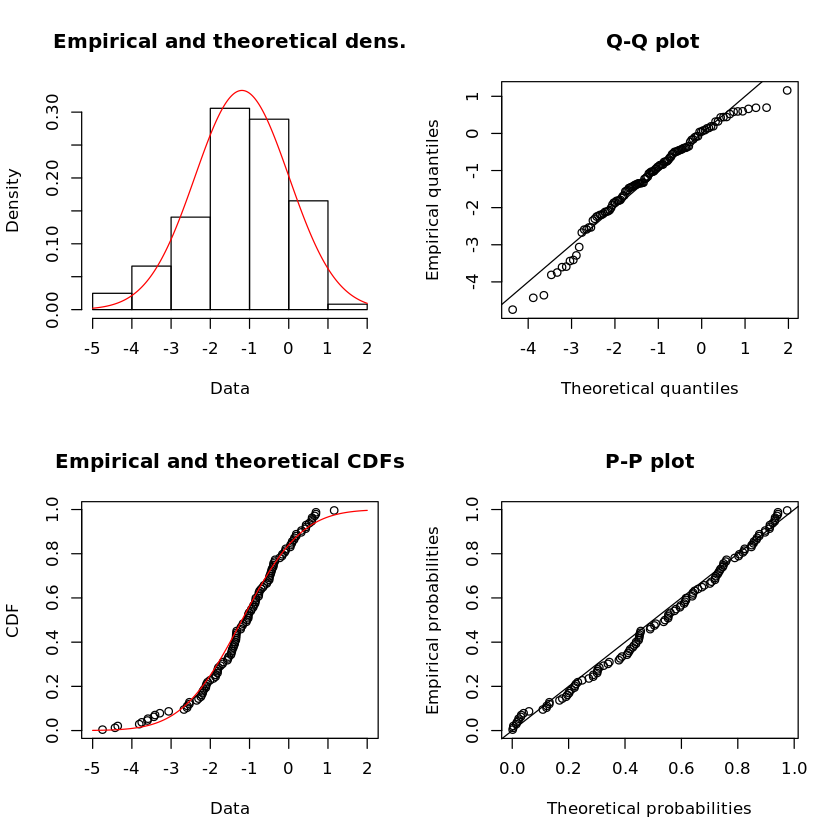

In [130]:
## Here removing the top 3 values
gspm<-subset(gspm,corrFactor < 3.5)

## Review the distribution fit options: log-normal, gamma or Weibull
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspm$corrFactor),"norm"); plot(tstdist)	#is log-normal best fit??

[1] "Gamma distribution fit:"


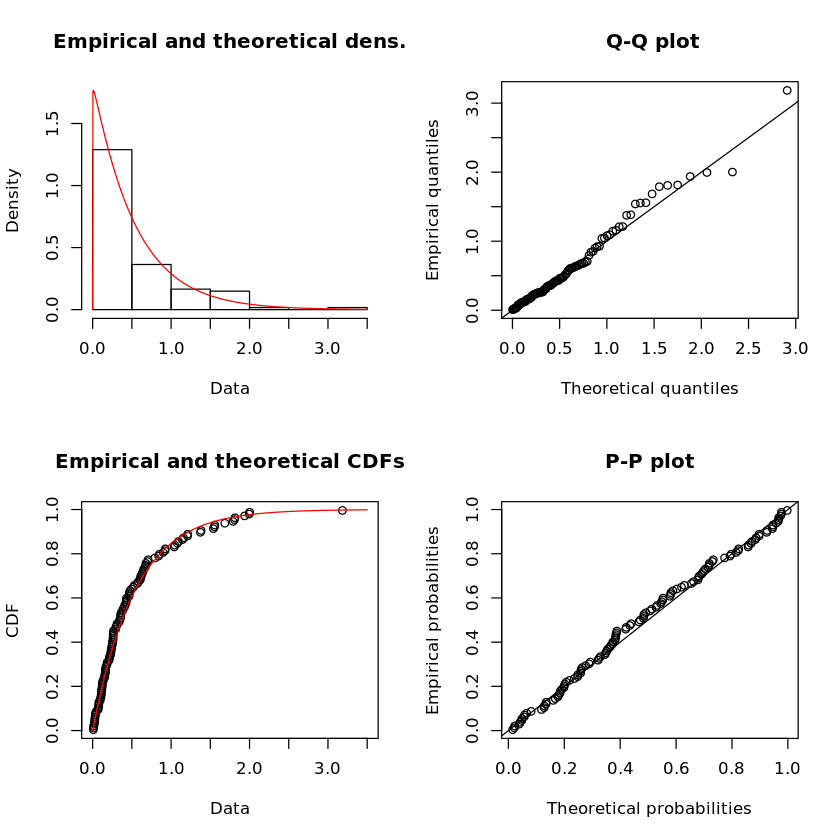

In [131]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspm$corrFactor,"gamma"); plot(tstdist)	#I think gamma/weibull is best

[1] "Weibull distribution fit:"


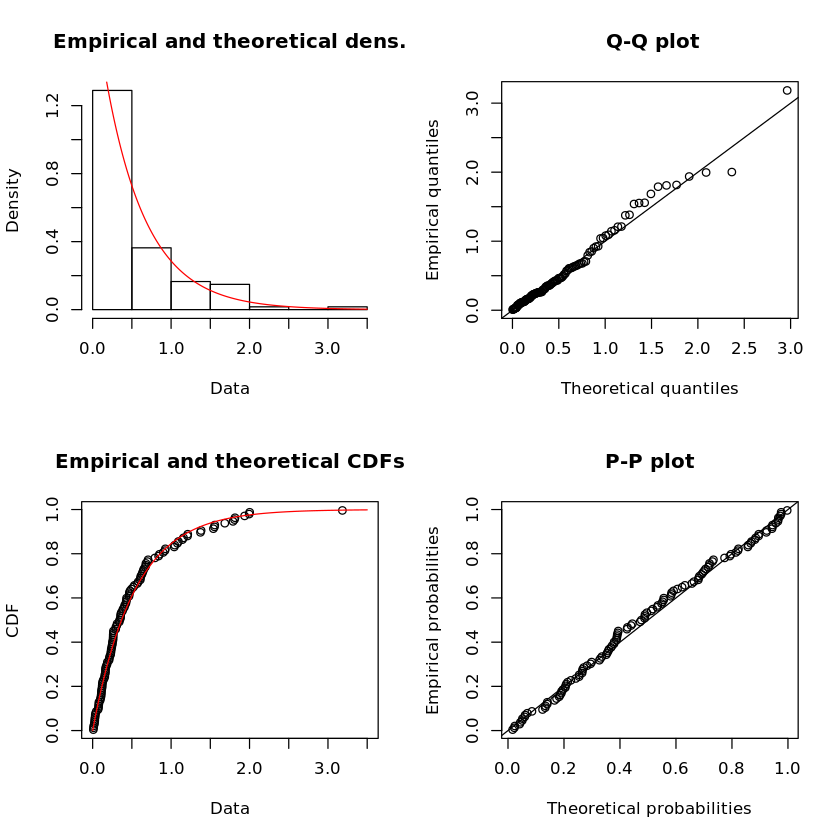

In [132]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspm$corrFactor,"weibull"); plot(tstdist)

Below we compare the mean and limits of the correction factors for the Gamma and Log-normal distributions. The Gamma is a better fit. Using the gamma, the number of seals is anywhere from 3% to 300% of the tag counts, mean being 87%

In [133]:
## Checking to compare 95% confidence limits
cfdist<-fitdist(log(gspm$corrFactor),"norm")$estimate
# lower 95% - mean - upper 95%
print("Log-normal: lower95 - mean - upper95")
paste(round(exp(cfdist[1] - (1.96*cfdist[2])),3),"-",round(exp(cfdist[1]),3),"-",round(exp(cfdist[1] + (1.96*cfdist[2])),3))
# versus
print("Gamma: lower95 - mean - upper95")
cfdist<-fitdist(gspm$corrFactor,"gamma")$estimate
paste(round(qgamma(0.025,cfdist[1],cfdist[2]),3),"-",round(cfdist[1]/cfdist[2],3),"-",round(qgamma(0.975,cfdist[1],cfdist[2]),3))


[1] "Log-normal: lower95 - mean - upper95"


[1] "0.029 - 0.303 - 3.175"

[1] "Gamma: lower95 - mean - upper95"


[1] "0.014 - 0.535 - 1.959"

#### Option 2: the Q coefficients
As with the correction factors above, the the region-specific Q coefficient values are more numerous, but let's inspect the general values too.

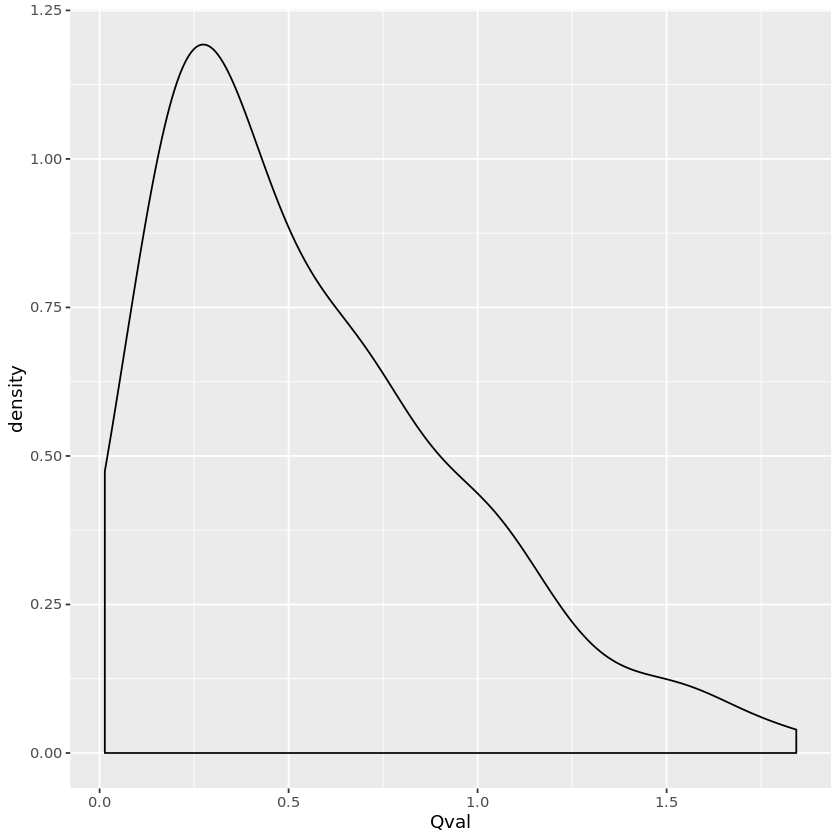

In [134]:
## Checking the distribution of the region-specific tagger values
ggplot(gspmQ,aes(x=Qval)) + geom_density()


No need to filter any values in the region-specific estimates of Qval.
Let's review the distribution fitting options for the region-specific Qval data:

[1] "Log-normal distribution fit:"


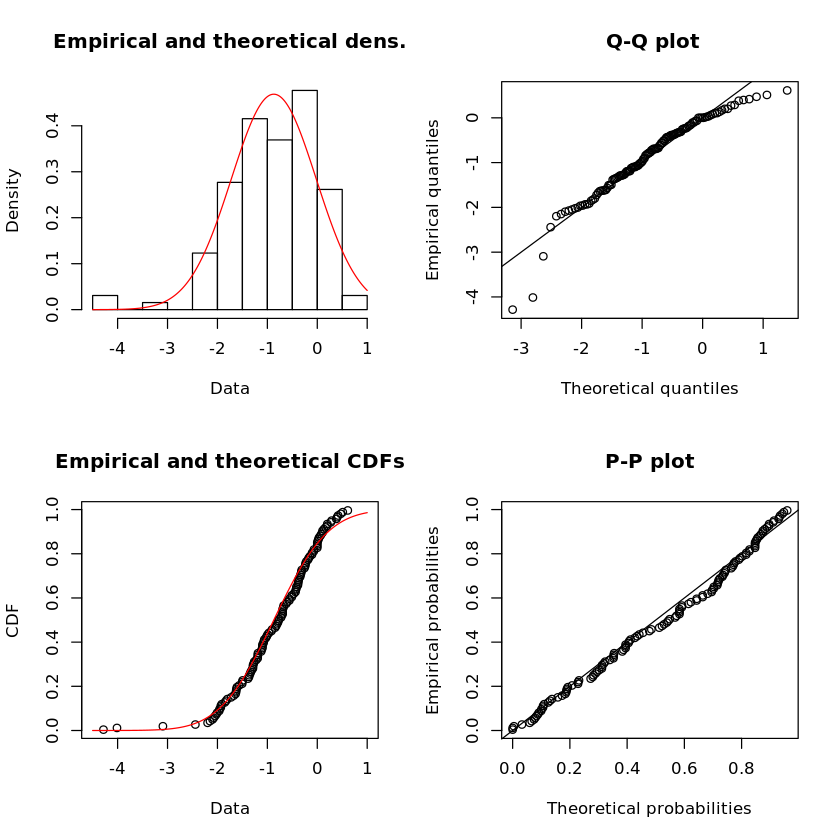

In [135]:
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspmQ$Qval),"norm"); plot(tstdist)

[1] "Gamma distribution fit:"


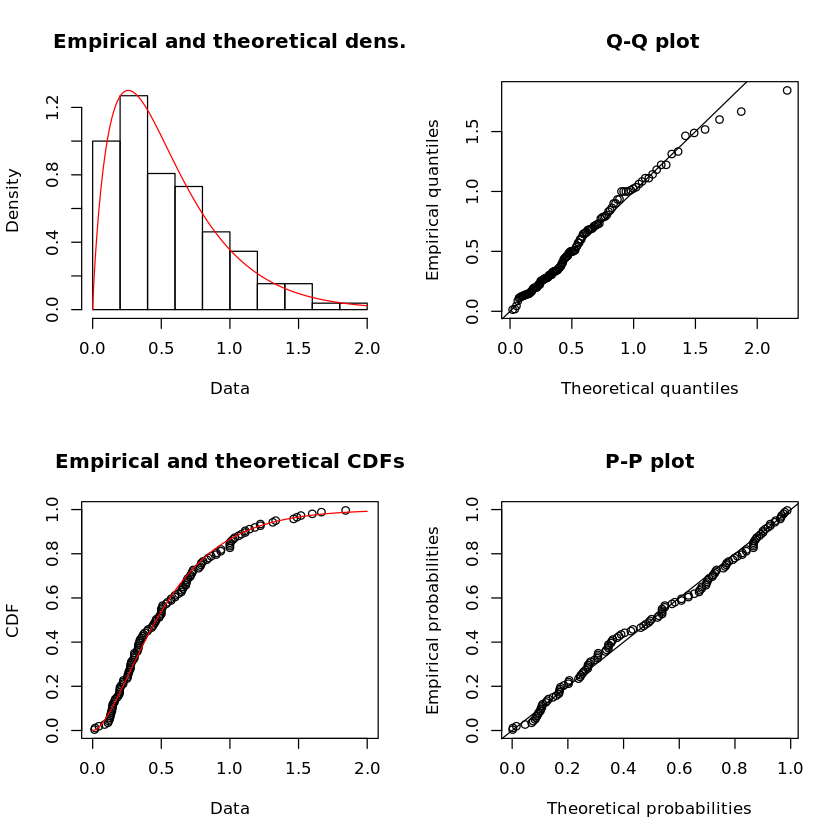

In [136]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspmQ$Qval,"gamma"); plot(tstdist)

[1] "Weibull distribution fit:"


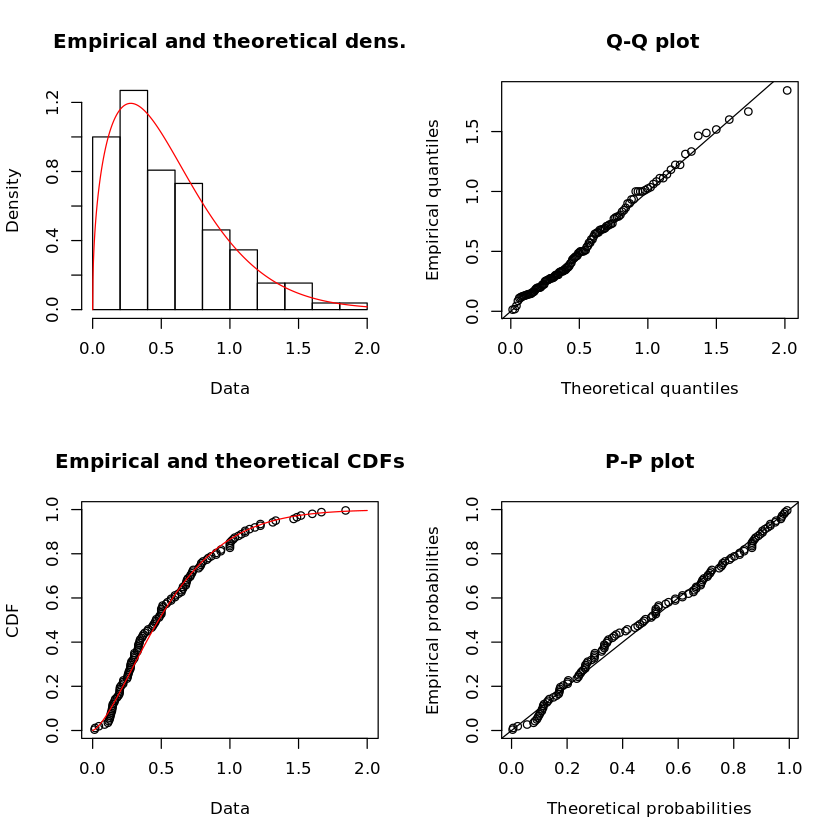

In [137]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspmQ$Qval,"weibull"); plot(tstdist)

Weibull is certainly the best fit. So:

In [138]:
qdist<-fitdist(gspmQ$Qval,"weibull")$estimate
weimean<-qdist[2]*gamma(1+1/qdist[1])
print("Weibull: lower95 - mean - upper95")
paste(round(qweibull(0.025,qdist[1],qdist[2]),3),"-",round(weimean,3),"-",round(qweibull(0.975,qdist[1],qdist[2]),3))

[1] "Weibull: lower95 - mean - upper95"


[1] "0.049 - 0.561 - 1.52"

Let's now check the general Q coefficient estimates:

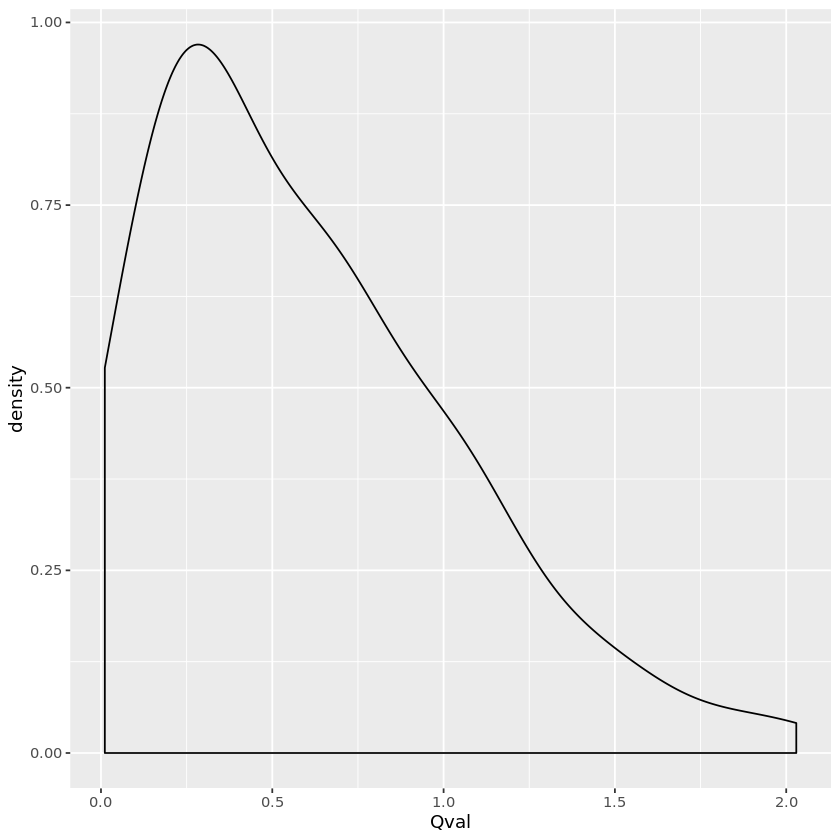

In [139]:
## Checking the distribution of the general tagger values
ggplot(gspmQG,aes(x=Qval)) + geom_density()

Let's review the distribution fitting options for the general Qval data:

[1] "Log-normal distribution fit:"


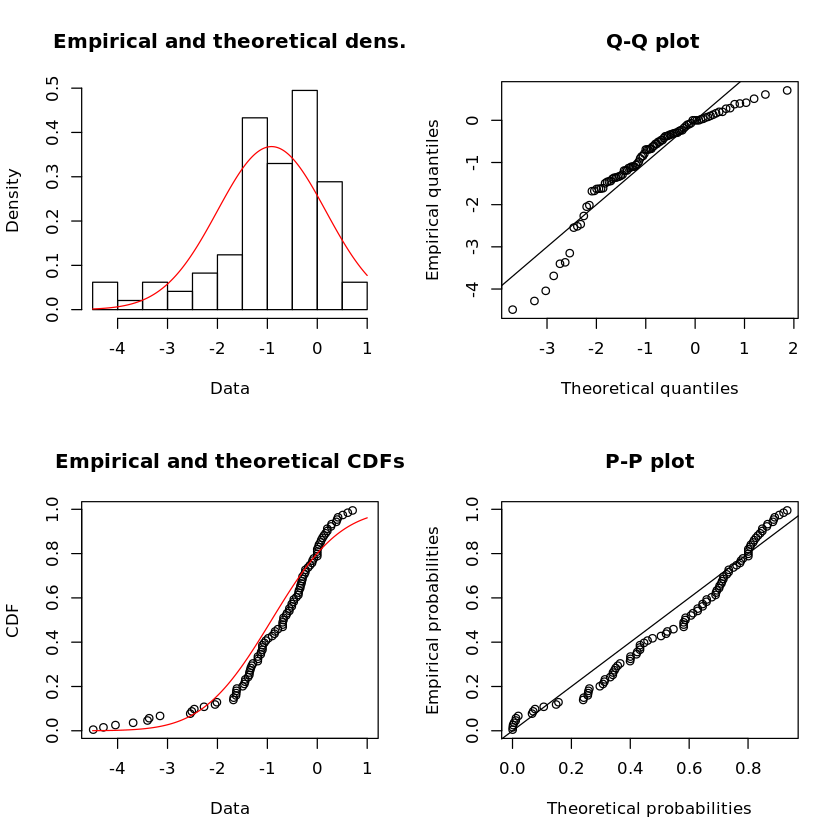

In [140]:
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspmQG$Qval),"norm"); plot(tstdist)

[1] "Gamma distribution fit:"


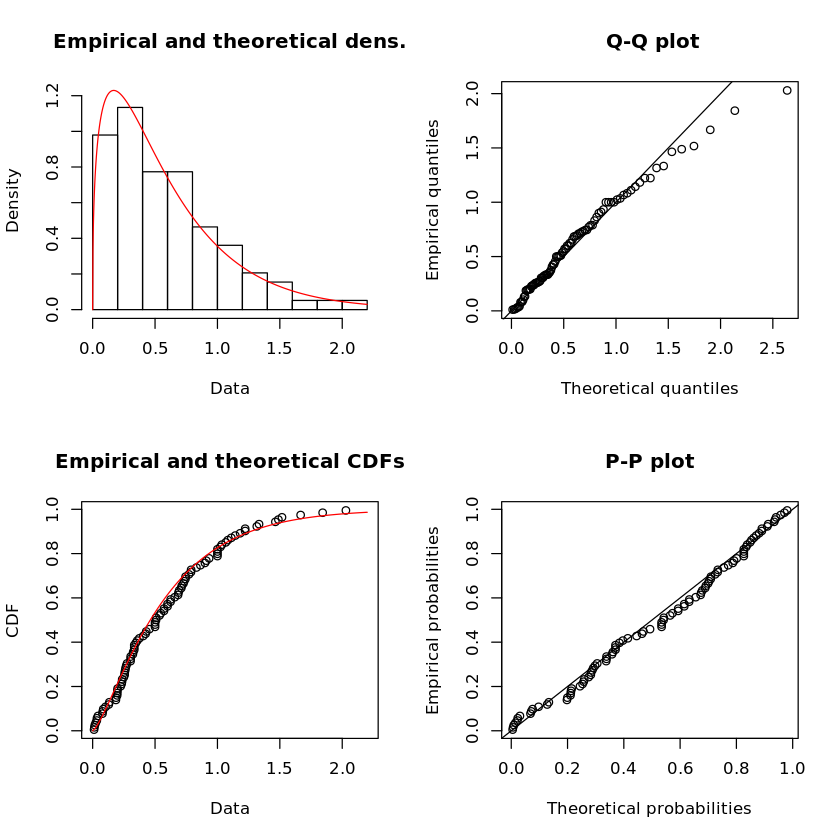

In [141]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspmQG$Qval,"gamma"); plot(tstdist)

[1] "Weibull distribution fit:"


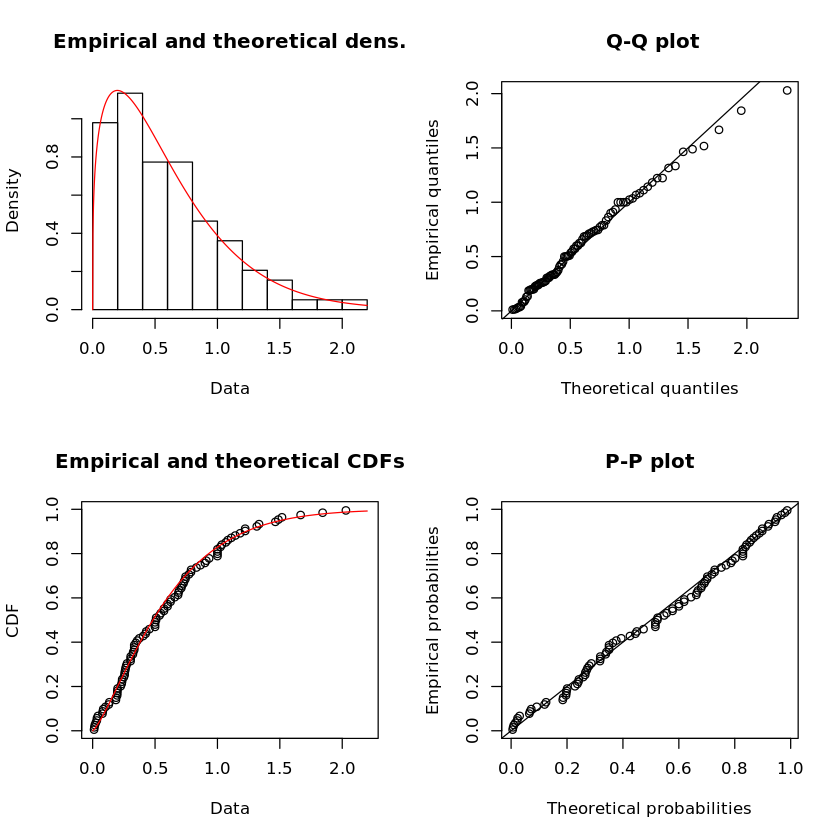

In [142]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspmQG$Qval,"weibull"); plot(tstdist)

Nice! Again Weibull is the better fit. Then let's see the distribution values:

In [143]:
qdist<-fitdist(gspmQG$Qval,"weibull")$estimate
weimean<-qdist[2]*gamma(1+1/qdist[1])
print("Weibull: lower95 - mean - upper95")
paste(round(qweibull(0.025,qdist[1],qdist[2]),3),"-",round(weimean,3),"-",round(qweibull(0.975,qdist[1],qdist[2]),3))

[1] "Weibull: lower95 - mean - upper95"


[1] "0.037 - 0.594 - 1.775"

The region-specific estimates are less numerous and more conservative than the general estimates.

## Calculating the number of seals from the tags
Let's calculate seal numbers using the region-specific form:

In [144]:
cival=90
countByQ<-getMapEstimates(cdf=gspmQ,crthr=0.5,taggers=subtaggers,nSealsFilt=8,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerQval",dist="weibull",cival=cival)
estByRegionQ<-as.data.frame(countByQ %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionQ<-rbind(estByRegionQ,data.frame(region="Total",lclNumSeals=round(sum(countByQ$lclNumSeals)),estNumSeals=round(sum(countByQ$estNumSeals)),uclNumSeals=round(sum(countByQ$uclNumSeals))))
print(estByRegionQ)

  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1021        2386        5964
2    EA1        2322        5853       14494
3    EA2        2135        4882       12216
4    QMA        2839        7224       17880
5    RSS        8547       24177       59340
6    WAP        3087        8388       20608
7  Total       19951       52910      130502


If we were to use the general form:

In [145]:
cival=90
countByQG<-getMapEstimates(cdf=gspmQG,crthr=0.5,taggers=subtaggers,nSealsFilt=8,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerQval",dist="weibull",cival=cival)
estByRegionQG<-as.data.frame(countByQG %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionQG<-rbind(estByRegionQG,data.frame(region="Total",lclNumSeals=round(sum(countByQG$lclNumSeals)),estNumSeals=round(sum(countByQG$estNumSeals)),uclNumSeals=round(sum(countByQG$uclNumSeals))))
print(estByRegionQG)


  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1039        2522        6321
2    EA1        2377        6233       15437
3    EA2        2176        5157       12920
4    QMA        2895        7716       19072
5    RSS        8797       25979       63666
6    WAP        3167        8965       22038
7  Total       20451       56572      139454


For comparison, let's see the estimates using the original correction factors:

In [146]:
cival=90
countBySS<-getMapEstimates(cdf=gspm,crthr=0.5,taggers=subtaggers,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerCorrFactor",dist="gamma",cival=cival)
estByRegionSS<-as.data.frame(countBySS %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionSS<-rbind(estByRegionSS,data.frame(region="Total",lclNumSeals=round(sum(countBySS$lclNumSeals)),estNumSeals=round(sum(countBySS$estNumSeals)),uclNumSeals=round(sum(countBySS$uclNumSeals))))
print(estByRegionSS)


  region lclNumSeals estNumSeals uclNumSeals
1    AMU         958        2291        6840
2    EA1        2115        5602       16748
3    EA2        2042        4720       14096
4    QMA        2582        6917       20686
5    RSS        7333       22882       68478
6    WAP        2736        7969       23797
7  Total       17766       50381      150645


Unfortunately, the numbers using the original correction factor are probably incorrect. As evident in the graph below comparing estimates to the expert count, the values are lower than they should. So, we cannot work with the estimates from the original correction Factor because the sample of surveyors is too biased!
* The blue line is the 1:1 relationship, our expectation if the values are correct
* The red line is the resulting relationship. Note the substatial under-estimation

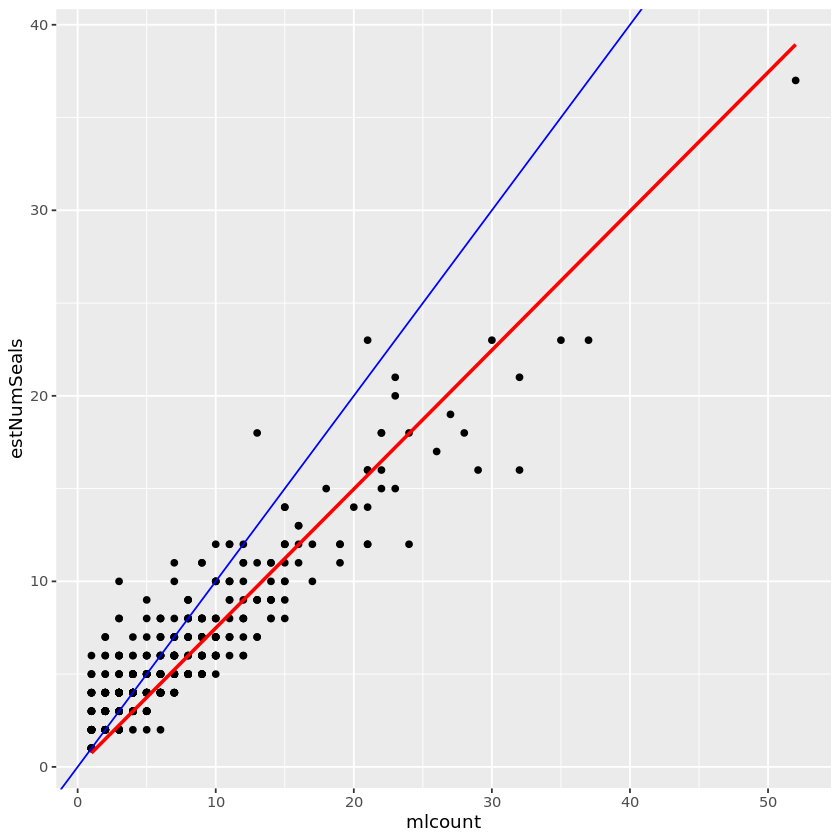

In [147]:
countBySS<-merge(countBySS,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countBySS,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")

We can do the same evaluation for the Q coefficients from the region-specific estimates, and see that these seem to underestimate a little the true number of seals in images

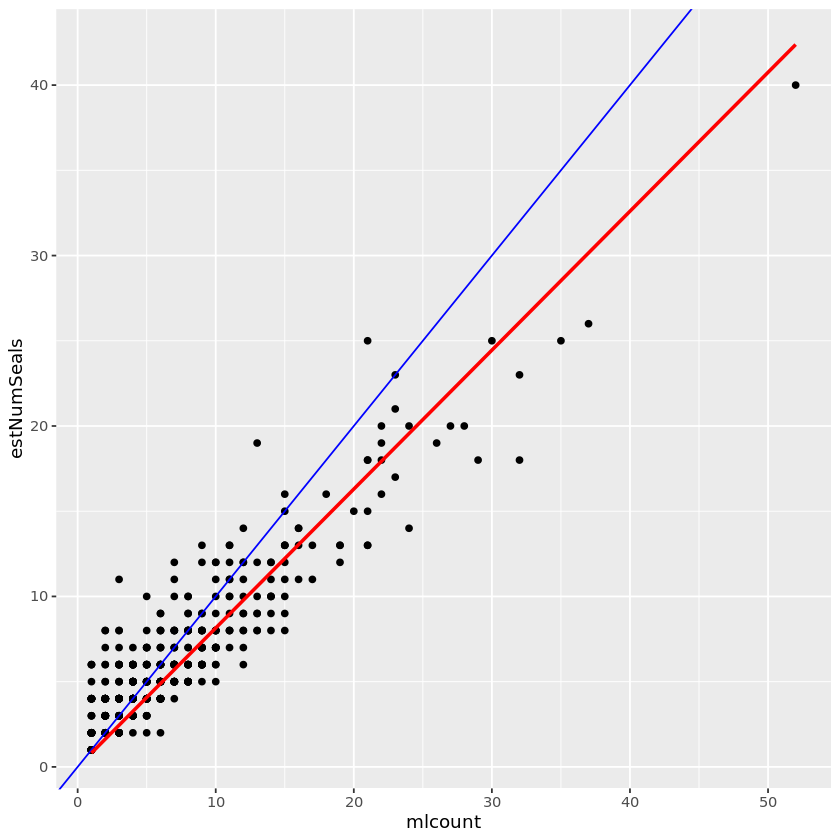

In [148]:
countByQ<-merge(countByQ,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countByQ,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")


Using the general estimates for the Q coefficients works better when compared to the expert. This is expected, as this method produced the highest count estimates.

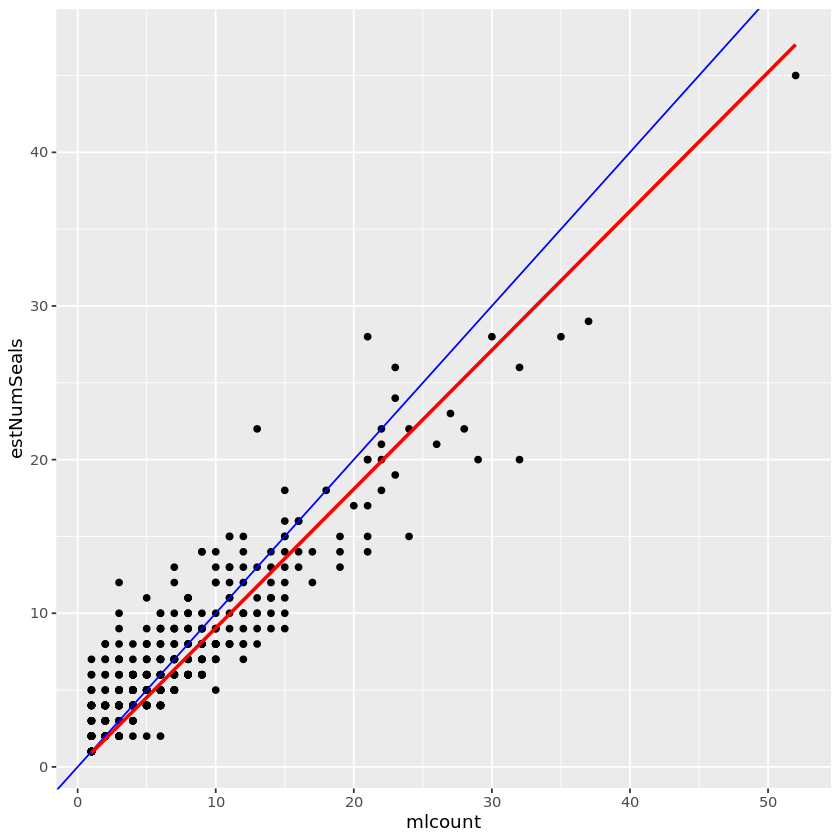

In [151]:
countByQG<-merge(countByQG,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countByQG,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")


## Reviewing results

The above results indicate that the distribution of Qvalues and correction factors from the sample of taggers from which these could be estimated results in an underestimate of the true presence of seals in maps (as measured by the expert's counts). Thus, we could use any of the above three correction methods and still need to inflate results a little bit.

But before we do the inflation, we have some very high tag counts. These indicate unrealistic numbers of seals in images. Inspecting these...  
  
Aside:
Incredibly, there are still problems in the data like this one:  
 mapId  region  mapViewId taggerId year regionMapViewId regionMapId regionTaggerId  
357856     QMA     218627   138101 2011       QMA218627   QMA357856      QMA138101  
357856     QMA     218621   138101 2011       QMA218621   QMA357856      QMA138101  
NOTE: same taggerId, same mapId, different viewId??? This should not be the case. We need to remember to consider views as 1:n with tagger+map.

In [152]:
tg<-tags; tg$tagCount<-1
tg<-merge(tg,views[,c("regionMapViewId","regionMapId")],by="regionMapViewId",all.x=T)
tgcounts<-aggregate(tagCount~regionMapId+regionTaggerId+region+year,w,sum)
sum(tgcounts$tagCount>100)  #44 cases in 40 maps
NROW(unique(subset(tgcounts,tagCount>100)$regionMapId))/nrow(tgcounts)  #40 maps out of 18,031, or 0.1%


[1] 44

[1] 0.001227333

Can we filter out these crazy count events before doing the inflation? Here we assume that counts of > 100 seals in maps are erroneous count events. Listing all map views with survey events in which the tagger placed > 100 tags:

In [153]:
tcdf<-ldply(.data=unique(subset(tgcounts,tagCount>100)$regionMapId), .fun=function(z,tgcounts,views){
			ovis<-NROW(unique(subset(tgcounts,regionMapId==z)$regionTaggerId))
			mval<-subset(tgcounts,tagCount>100 & regionMapId==z)
			mval<-mval[,c("regionTaggerId","region","regionMapId","tagCount")]
			mval$totalViews<-ovis
			return(mval)
		},tgcounts=tgcounts,views=views)

tcdf<-tcdf[order(tcdf$regionMapId),]
print(tcdf)

   regionTaggerId region regionMapId tagCount totalViews
2      QMA6406885    QMA    QMA11295      193          1
3      QMA6406885    QMA    QMA11858      554          1
1        QMA32474    QMA    QMA13002      119          6
4        QMA32474    QMA   QMA357856      123          2
5      QMA3915005    QMA   QMA357856      120          2
28     RSS8515149    RSS  RSS1124631      308          2
29     RSS8515149    RSS  RSS1125743      269          2
17    RSS26282138    RSS  RSS1255032     1769          1
18    RSS26282138    RSS  RSS1255476      238          1
7     RSS25957678    RSS  RSS1306349      507          2
21    RSS26284340    RSS  RSS1454600      110          4
25    RSS26296076    RSS  RSS1474993      154          6
26    RSS26296076    RSS  RSS1474994      255          6
9     RSS26253045    RSS  RSS1476599      138          6
10    RSS26296076    RSS  RSS1476599      295          6
22    RSS26284340    RSS  RSS1551287      894         12
8     RSS26208460    RSS  RSS15

Note that some maps in which high-count events exist have been seen by more than 1 tagger. For example, look at the regionMapId above for RSS1605480. It was inspected by 21 different taggers, and only 3 had counts > 100. 

In [154]:
subset(tgcounts, regionMapId=="RSS1605480")

,regionMapId,regionTaggerId,region,year,tagCount
,<chr>,<chr>,<chr>,<int>,<dbl>
13700,RSS1605480,RSS10170854,RSS,2011,3
14004,RSS1605480,RSS15190134,RSS,2011,9
14762,RSS1605480,RSS1982104,RSS,2011,9
15555,RSS1605480,RSS21930914,RSS,2011,9
16151,RSS1605480,RSS2204298,RSS,2011,3
16223,RSS1605480,RSS22225,RSS,2011,2
16378,RSS1605480,RSS2405587,RSS,2011,3
18639,RSS1605480,RSS25943492,RSS,2011,9
19323,RSS1605480,RSS25976719,RSS,2011,1


Clearly, these 3 taggers were mistaken. We can safely remove these events from the data to obtain a more accurate estimate for map RSS1605480. However, we cannot do the same for those maps inspected by only one tagger (e.g., RSS938501), or if these are 1 of only 2 counts.

In [155]:
subset(tgcounts,regionMapId=="RSS1124631")

,regionMapId,regionTaggerId,region,year,tagCount
,<chr>,<chr>,<chr>,<int>,<dbl>
26545,RSS1124631,RSS7813785,RSS,2011,2
27576,RSS1124631,RSS8515149,RSS,2011,308


In the above example, the count of 308 seals is most likely wrong.  
In another example, there are only 2 counts, and both are > 100:

In [156]:
subset(tgcounts,regionMapId=="QMA357856")

,regionMapId,regionTaggerId,region,year,tagCount
,<chr>,<chr>,<chr>,<int>,<dbl>
12005,QMA357856,QMA32474,QMA,2011,123
12795,QMA357856,QMA3915005,QMA,2011,120


All these extreme counts come from a handful of taggers and events. Are they consistently and throughout all their work over-counting? Let's visualize if and how much these taggers may over-count.

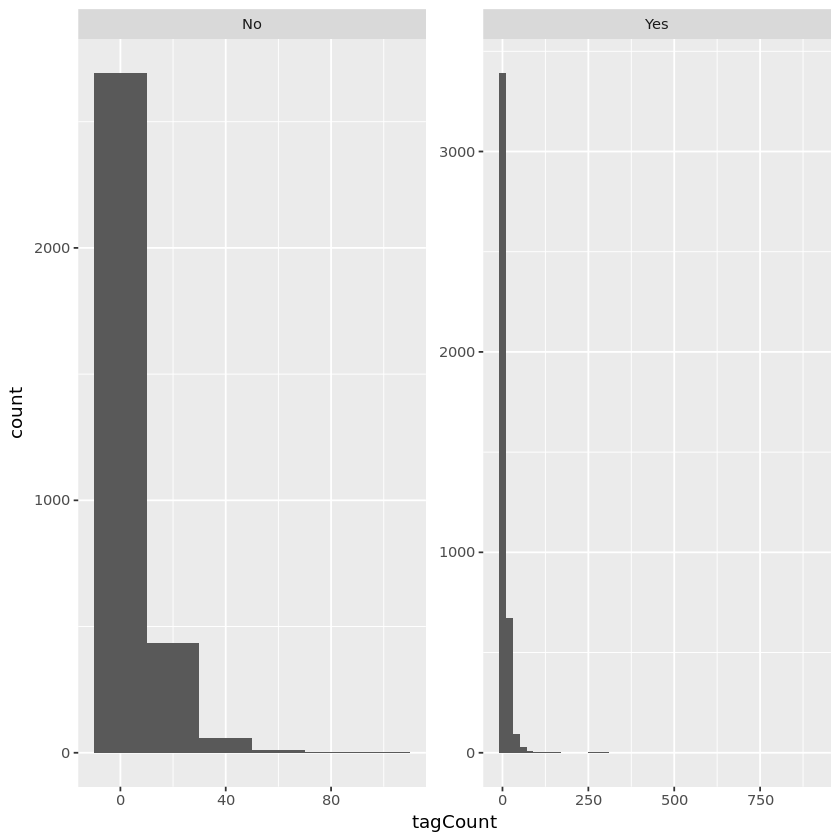

In [157]:
tgcounts$taggerId<-substr(tgcounts$regionTaggerId,4,nchar(tgcounts$regionTaggerId))
tcdf$taggerId<-substr(tcdf$regionTaggerId,4,nchar(tcdf$regionTaggerId))
htgcounts<-subset(tgcounts,taggerId %in% tcdf$taggerId) 	#all the counts from the high taggers
mtgcounts<-subset(tgcounts,regionMapId %in% wwt$regionMapId)	#all the map counts from maps inspected by the high taggers
mtgcounts$highTagger<-ifelse(mtgcounts$taggerId %in% tcdf$taggerId,"Yes","No")
ndf<-aggregate(tagCount~regionMapId+highTagger,subset(mtgcounts,highTagger=="No"),max)
ydf<-subset(mtgcounts,highTagger=="Yes" & regionMapId %in% ndf$regionMapId,select=c("regionMapId","highTagger","tagCount"))
pdf<-rbind(ndf,ydf)
ggplot(pdf,aes(x=tagCount)) + geom_histogram(binwidth=20) + facet_wrap(~highTagger,scales="free")

The above graph has two panes. The "No" pane is the density distribution of counts by the taggers that never counted > 100 seals in a map. The "Yes" pane is the distribution of values of the "high-counters". Note that the x-axis is very different among panes. But if plotting only the counts < 100 for the high-counters, the result is very similar to the rest of the taggers. This is good news, as it suggests that the high-counters only tagged excessibly in very few survey events.

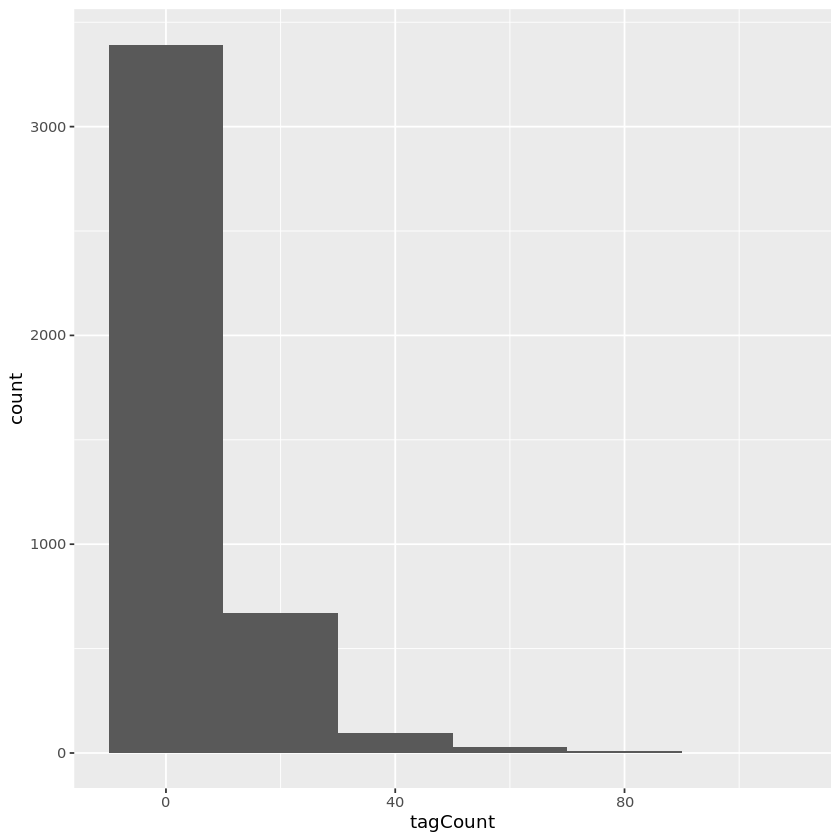

In [158]:
ggplot(subset(pdf,highTagger=="Yes" & tagCount<100),aes(x=tagCount)) + geom_histogram(binwidth=20)

So, it seems that what needs to happen is to use the information in the table tcdf above in two ways. First, for those maps with > 3 views, remove the high-count view, as there is enough information in the other 3 or more views to inform the real number of tags. Second, for those maps viewed only once or twice, adjust the high count. One way to do this is to use the Qval for the tagger, not the mean of the distribution, if it exists. If it does not exist, we use the average Qval of those individual high-counters for which there exists a Qval. 

The code below removes the tag reords from the high-count events that can be safely removed (i.e., for maps for which there exist at least 3 other counts that do not exceed 100 tags).

In [159]:
tcdff<-ldply(.data=unique(tcdf$regionMapId), .fun=function(m,tcdf){
			ttdf<-subset(tcdf,regionMapId==m)
			nr<-nrow(ttdf)
			nh<-unique(ttdf$totalViews)
			if(nh<(nr+2)){
				rdf<-ttdf
			}else{
				rdf<-data.frame(regionTaggerId=NA, region=NA, regionMapId=NA, tagCount=NA, totalViews=NA)
			}
			
		},tcdf=tcdf)
tcdff<-na.omit(tcdff)
tcdfr<-subset(tcdf,!regionMapId %in% tcdff$regionMapId)
tcdfr$taggerMap<-paste0(tcdfr$regionTaggerId,":",tcdfr$regionMapId)
## Confirming:
orv<-nrow(tgvutm)
tgvutm<-subset(tgvutm,!paste0(regionTaggerId,":",regionMapId) %in% tcdfr$taggerMap)
nrow(tgvutm)==orv-sum(tcdfr$tagCount)	## TRUE


[1] TRUE

Now that these high-count events have been removed, we use the individual's Qvalue (not the sample mean) or its approximation for the remaining high-count events. 

We start with region-specific Qvalues (underestimates by 31%):

[1] "QMA6406885"  "RSS8515149"  "RSS26282138" "RSS25957678" "RSS27728388"
[6] "RSS26284006" "WAP30585646"

  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1338        3126        7813
2    EA1        3042        7668       18988
3    EA2        2797        6396       16003
4    QMA        3553        7470       18837
5    RSS       10660       27885       68989
6    WAP        3703        7684       19404
7  Total       25090       60226      150032


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.310   1.310   2.620   3.451   3.930 472.910 

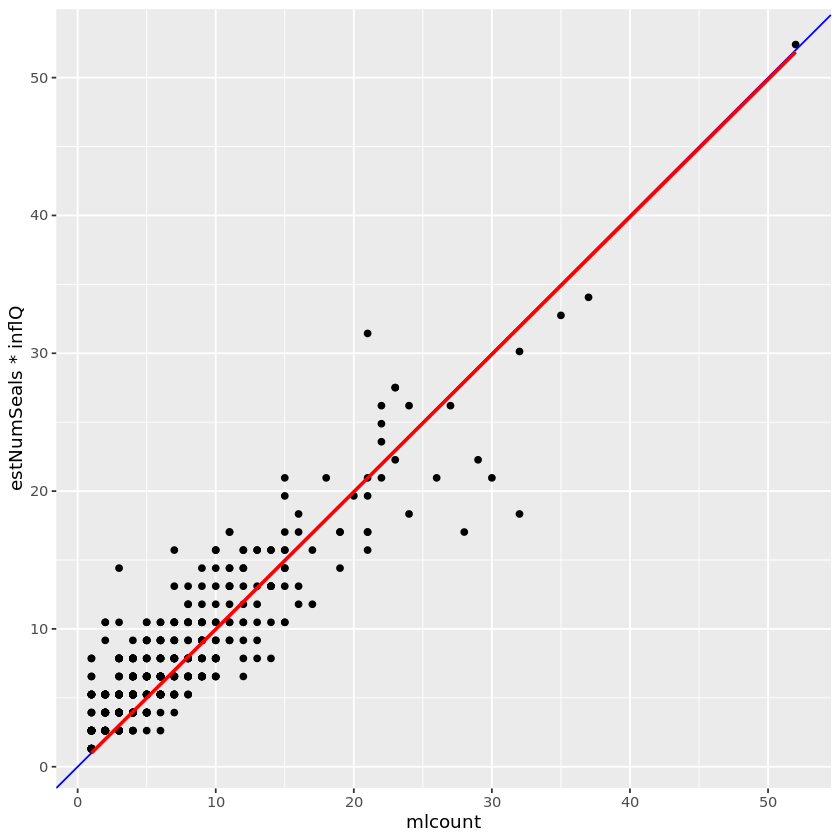

In [176]:
indivQdf<-subset(gspmQ,regionTaggerId %in% tcdff$regionTaggerId, select=c("regionTaggerId","Qval"))
unique(subset(tcdff,!regionTaggerId %in% indivQdf$regionTaggerId)$regionTaggerId)   ## Do we have value for all? No.
indivQdf<-rbind(indivQdf,data.frame(regionTaggerId=unique(subset(tcdff,!regionTaggerId %in% indivQdf$regionTaggerId)$regionTaggerId),Qval=mean(indivQdf$Qval)))   ## For the missing we use the average of the highTaggers for which we have Qvals/corrFactors
countByQ<-getMapEstimates(cdf=gspmQ,crthr=0.5,taggers=subtaggers,nSealsFilt=8,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerQval",dist="weibull",regional=TRUE,indivCFdf=indivQdf,cival=cival)
inflQ<-1.31    #inflating...
estByRegionQ<-as.data.frame(countByQ %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)*inflQ),estNumSeals=ceiling(sum(estNumSeals)*inflQ),uclNumSeals=ceiling(sum(uclNumSeals)*inflQ)))
estByRegionQ<-rbind(estByRegionQ,data.frame(region="Total",lclNumSeals=round(sum(countByQ$lclNumSeals)*inflQ),estNumSeals=round(sum(countByQ$estNumSeals)*inflQ),uclNumSeals=round(sum(countByQ$uclNumSeals)*inflQ)))
print(estByRegionQ)
countByQ<-merge(countByQ,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countByQ,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals*inflQ)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")
summary(countByQ$estNumSeals*inflQ)

For the continent-wide Qvalues (underestimates by 42%):

[1] "6406885"  "26282138" "25957678" "27728388" "26284006"

  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1385        2172        5793
2    EA1        3197        6750       17171
3    EA2        2948        4678       12482
4    QMA        3839        7629       19544
5    RSS       11742       31684       78345
6    WAP        3989        7632       19579
7  Total       27098       60540      152911


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.420   1.420   1.420   3.469   2.840 430.260 

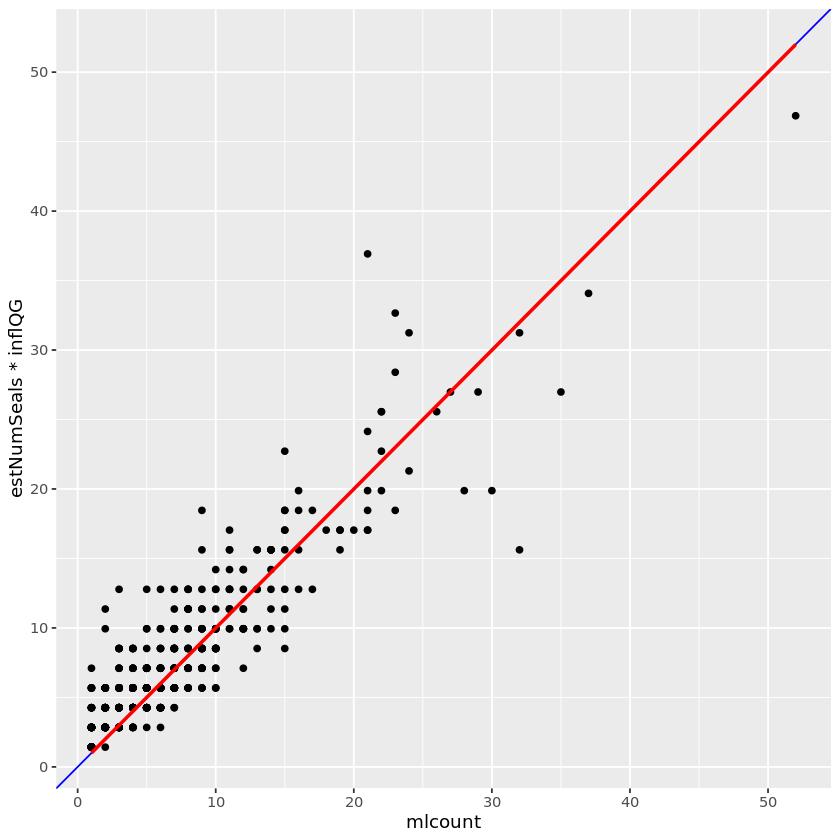

In [166]:
indivQdf<-subset(gspmQG,taggerId %in% tcdff$taggerId, select=c("taggerId","Qval"))
unique(subset(tcdff,!taggerId %in% indivQdf$taggerId)$taggerId)   
indivQdf<-rbind(indivQdf,data.frame(taggerId=unique(subset(tcdff,!taggerId %in% indivQdf$taggerId)$taggerId),Qval=mean(indivQdf$Qval)))   
countByQG<-getMapEstimates(cdf=gspmQG,crthr=0.5,taggers=subtaggers,nSealsFilt=8,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerQval",dist="weibull",regional=FALSE,indivCFdf=indivQdf,cival=cival)
inflQG<-1.42
estByRegionQG<-as.data.frame(countByQG %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)*inflQG),estNumSeals=ceiling(sum(estNumSeals)*inflQG),uclNumSeals=ceiling(sum(uclNumSeals)*inflQG)))
estByRegionQG<-rbind(estByRegionQG,data.frame(region="Total",lclNumSeals=round(sum(countByQG$lclNumSeals)*inflQG),estNumSeals=round(sum(countByQG$estNumSeals)*inflQG),uclNumSeals=round(sum(countByQG$uclNumSeals)*inflQG)))
print(estByRegionQG)
countByQG<-merge(countByQG,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countByQG,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals*inflQG)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")
summary(countByQG$estNumSeals*inflQG)

And if using the more general SS correction factor (underestimates by 46%):

[1] "QMA6406885"  "RSS8515149"  "RSS26282138" "RSS25957678" "RSS27728388"
[6] "RSS26284006" "WAP30585646"

  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1351        3231        9645
2    EA1        2983        7899       23615
3    EA2        2880        6656       19876
4    QMA        3620        8304       24643
5    RSS       10207       28996       86803
6    WAP        3802        8097       23994
7  Total       24840       63179      188573


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.41    1.41    2.82    3.62    4.23  596.43 

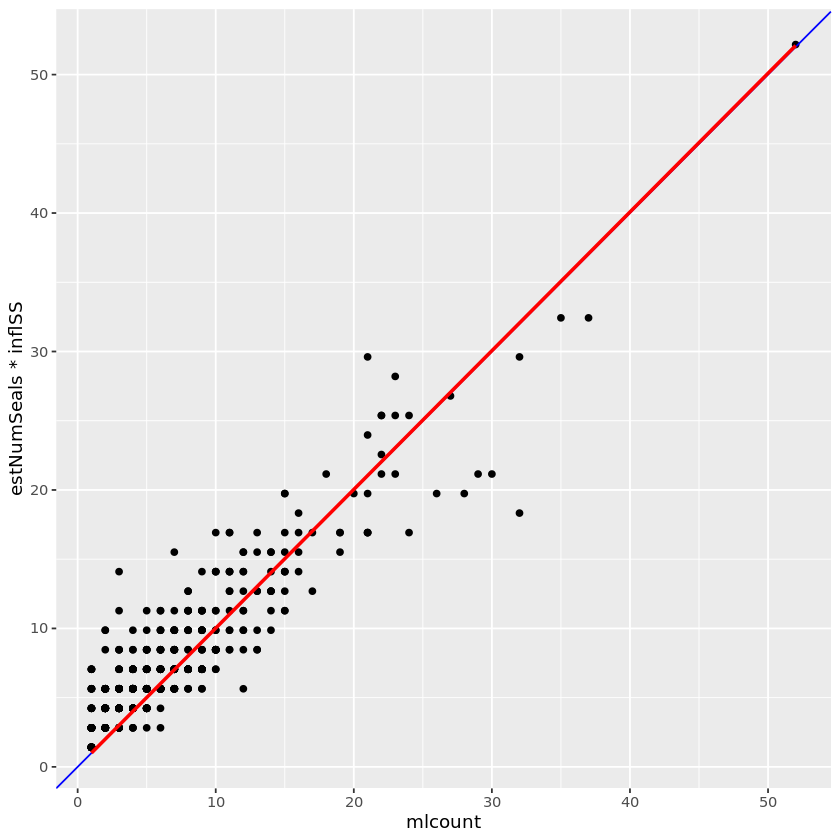

In [169]:
indivCFdf<-subset(gspm,regionTaggerId %in% tcdff$regionTaggerId, select=c("regionTaggerId","corrFactor"))
unique(subset(tcdff,!regionTaggerId %in% indivCFdf$regionTaggerId)$regionTaggerId)   
indivCFdf<-rbind(indivCFdf,data.frame(regionTaggerId=unique(subset(tcdff,!regionTaggerId %in% indivCFdf$regionTaggerId)$regionTaggerId),corrFactor=mean(indivCFdf$corrFactor)))   
countBySS<-getMapEstimates(cdf=gspm,crthr=0.5,taggers=subtaggers,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerCorrFactor",dist="gamma",regional=TRUE,indivCFdf=indivCFdf,cival=cival)
inflSS<-1.41
estByRegionSS<-as.data.frame(countBySS %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)*inflSS),estNumSeals=ceiling(sum(estNumSeals)*inflSS),uclNumSeals=ceiling(sum(uclNumSeals)*inflSS)))
estByRegionSS<-rbind(estByRegionSS,data.frame(region="Total",lclNumSeals=round(sum(countBySS$lclNumSeals)*inflSS),estNumSeals=round(sum(countBySS$estNumSeals)*inflSS),uclNumSeals=round(sum(countBySS$uclNumSeals)*inflSS)))
print(estByRegionSS)
countBySS<-merge(countBySS,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countBySS,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals*inflSS)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")
summary(countBySS$estNumSeals*inflSS)


Our correction using the region-specific factor (countByQ) is the top choice!  
After removing the high-count events and correcting a bit better the remaining, the region-specific Qvalue correction produced the narrower confidence interval (highest precision) and required least inflation.  
Some estimates are still a bit high:

In [177]:
countByQ$estNumSeals<-round(countByQ$estNumSeals*inflQ)
countByQ$uclNumSeals<-round(countByQ$uclNumSeals*inflQ)
countByQ$lclNumSeals<-round(countByQ$lclNumSeals*inflQ)
summary(countByQ$estNumSeals)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   3.000   3.452   4.000 473.000 

## Further shrinking too-high map estimates
It is unlikely that there will be > 100 seals in a map. So now we use an additional approach to shrink the values of seals per map to a reasonable size, for the very few maps that have these still too-high estimates. These estimates are the result of not sufficient shrinking of the extreme count events we attempted to correct above.  

Here we shrink the odd map estimates to some high quantile of the distribution of map counts for the hour. That is, we look at all map estimates of maps from any region taken at the same time, fit a probability density distribution to these, and then use the value for the 99th quantile of the distribution.  

First, we must add hour to our data. But before we do the shrinking, we examine if the extreme estimates are associated with a particular sensor. Recall that in Erebus Bay these were associated with QB02.

satId,regionMapId
<chr>,<int>
GE01,9
QB02,3385
WV01,7847
WV02,6212


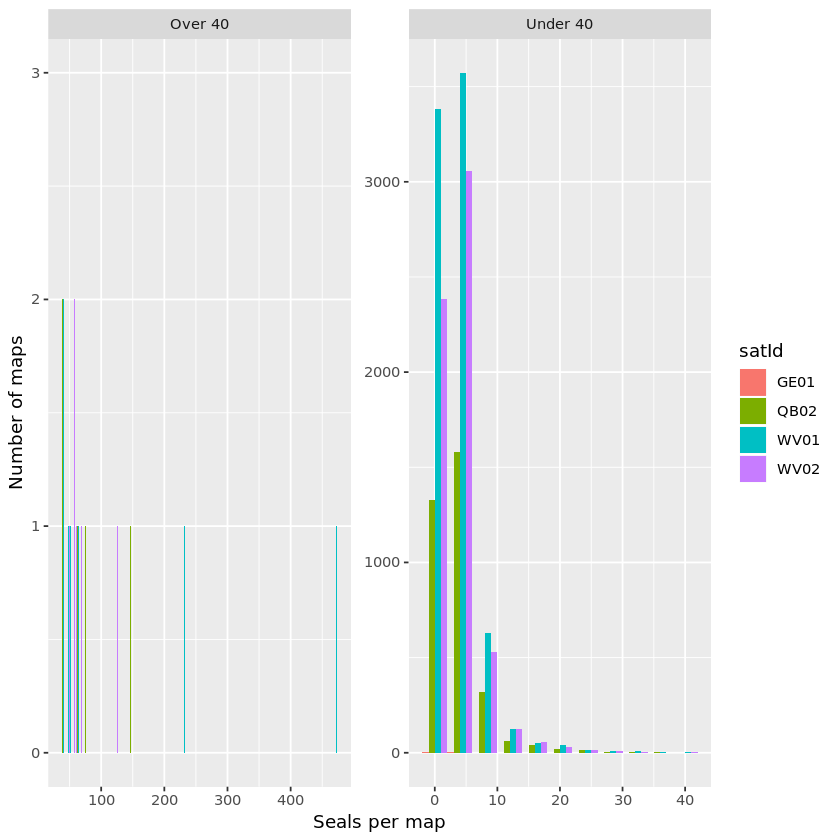

In [188]:
pdf<-merge(countByQ,unique(overlays[,c("overlayId","acquisition_date")]),by="overlayId",all.x=TRUE)
pdf$originHour<-format(pdf$acquisition_date,"%H")
pdf$originTZ<-format(pdf$acquisition_date,"%Z")
pdf$RSdate<-as.POSIXlt(pdf$acquisition_date,tz="Pacific/Auckland")   #Convert to Ross Sea time zone
pdf$RShour<-format(pdf$RSdate,"%H")
pdf<-merge(pdf,maps[,c("regionMapId","mapcoords.x1","mapcoords.x2")],by="regionMapId",all.x=TRUE)
pdf$abBin<-ifelse(pdf$estNumSeals<20,"Under 20",ifelse(pdf$estNumSeals>19 & pdf$estNumSeals<51,"20 to 50","Over 50"))
pdf$abBin2<-ifelse(pdf$estNumSeals<40,"Under 40","Over 40")
pdf$wvq<-ifelse(pdf$satId=="QB02","QB","WV")
ggplot(pdf,aes(x=estNumSeals)) + geom_histogram(aes(fill=satId),position="dodge",binwidth=4) + facet_wrap(~abBin2,scales="free") + labs(x="Seals per map",y="Number of maps")
aggregate(regionMapId~satId,pdf,NROW)

The results above suggest no relationship between sensor type and high-count map estimates. The number of possible outlier counts in maps (i.e., maps with counts > 40) is only 23 maps (out of 17,453).   
  
So, let's look at the distributions of values by hour, considering any map with > 40 seals as a possible outlier:

[1] 23

[1] 17453

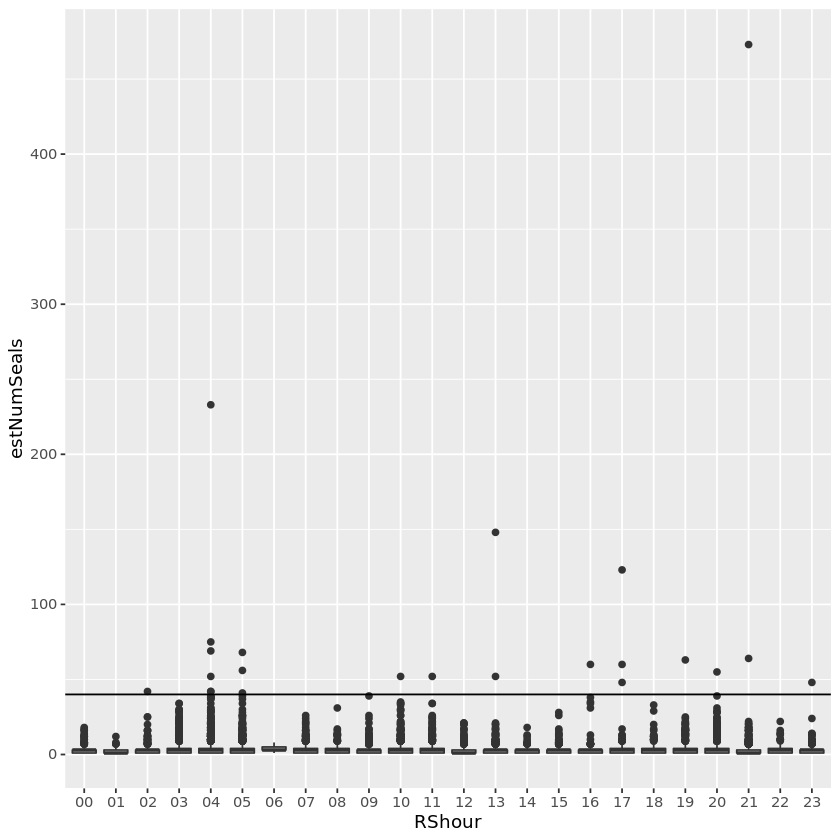

In [187]:
sum(pdf$abBin2=="Over 40");NROW(unique(pdf$regionMapId))
ggplot(pdf,aes(x=RShour,y=estNumSeals))+geom_boxplot() + geom_hline(yintercept=40)

Note the outliers - above the 40-seals line. The value for on the 21st hour is NOT credible. It comes from only 1 tagger and an image taken by WV01. We unsuccessfuly deflated this count to the value shown in the plot above.

In [183]:
g<-subset(tags,regionMapViewId %in% unique(subset(views,regionMapId=="RSS1255032")$regionMapViewId))
tt<-aggregate(tagId~regionTaggerId,g,NROW);names(tt)<-c("regionTaggerId","tagCount");print(tt)

  regionTaggerId tagCount
1    RSS26282138     1769


The same is the case for the outlier in the 4th hour:

In [184]:
g<-subset(tags,regionMapViewId %in% unique(subset(views,regionMapId=="RSS938501")$regionMapViewId))
tt<-aggregate(tagId~regionTaggerId,g,NROW);names(tt)<-c("regionTaggerId","tagCount");print(tt)

  regionTaggerId tagCount
1    RSS26284006      872


But some of these high counts may be legit, estimated from counts by several taggers.  So, we apply the following rule: we shrink any outlier value with mean tags > 100, and we shrink any outlier value with tags > 40 estimated from the count by a single tagger.  
  
We shrink the counts for these outlier map estimates by using the 99% value of a negative binomial distribution applied to the set of values for the same hour.

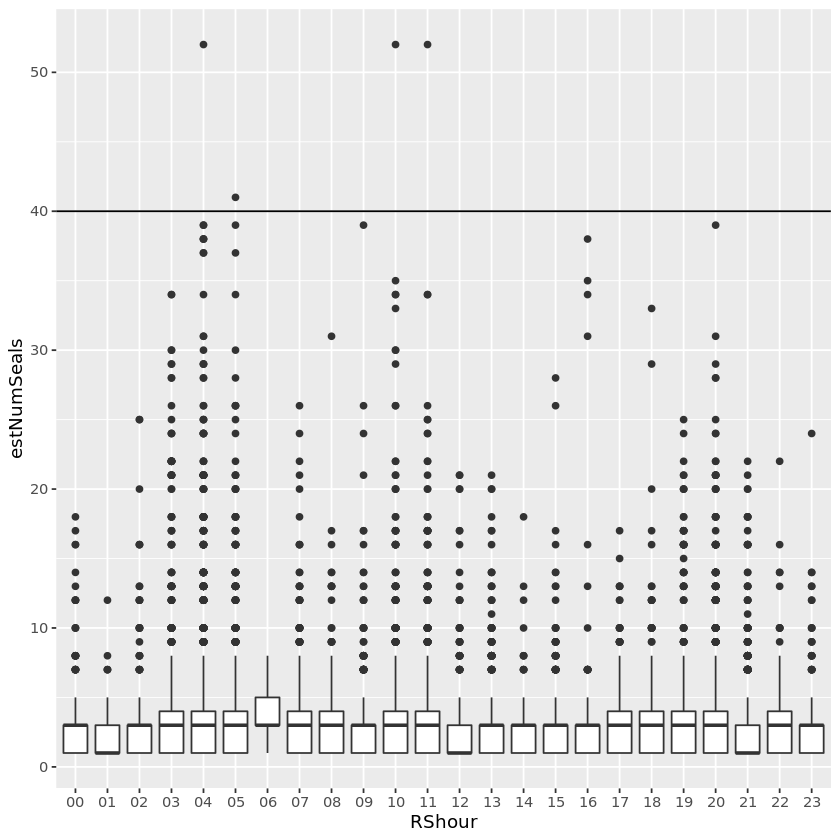

In [190]:
outs<-subset(pdf,estNumSeals>40)
outvals<-ldply(.data=outs$regionMapId,.fun=function(mm,outs,tags,views){
			g<-subset(tags,regionMapViewId %in% unique(subset(views,regionMapId==mm)$regionMapViewId))
			tou<-subset(outs,regionMapId==mm)
			ns<-tou$estNumSeals; nt<-tou$numTaggers; hr<-tou$RShour
			adf<-aggregate(tagId~regionTaggerId,g,NROW)
			tdf<-data.frame(Hour=hr,regionMapId=mm,estNumSeals=ns,numTaggers=nt,minTags=min(adf$tagId),maxTags=max(adf$tagId),meanTags=mean(adf$tagId))
			return(tdf)
		},outs=outs,tags=tags,views=views)
outvals$Hour<-as.character(outvals$Hour)
outvals<-subset(outvals,(meanTags>100) | (meanTags>40 & numTaggers==1))

counts<-pdf
for(mm in outvals$regionMapId){
	hv<-subset(outvals,regionMapId==mm)$Hour
	outh<-subset(counts, RShour==hv)	
	dv<-fitdist(outh$estNumSeals,"nbinom")$estimate
	nmv<-qnbinom(0.99,mu=dv[2],size=dv[1])
	counts$estNumSeals<-ifelse(counts$regionMapId==mm,nmv,counts$estNumSeals)
}
ggplot(counts,aes(x=RShour,y=estNumSeals))+geom_boxplot() + geom_hline(yintercept=40)

We end up with only 4 maps whose estimates are > 40, and now none is > 60. Aside: the highest count of seals in a map by the expert is 58. So the above outlier values are well within the realm of possible.  
    
We estimate the numbers one more time after this correction. This time there is no need to inflate, as the values were already inflated above.

  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1078        3148        7930
2    EA1        2500        7719       19261
3    EA2        2218        6461       16218
4    QMA        2837        7230       19047
5    RSS        8857       26585       69715
6    WAP        2938        7544       19644
7  Total       20428       60240      151815


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   3.000   3.363   4.000  52.000 

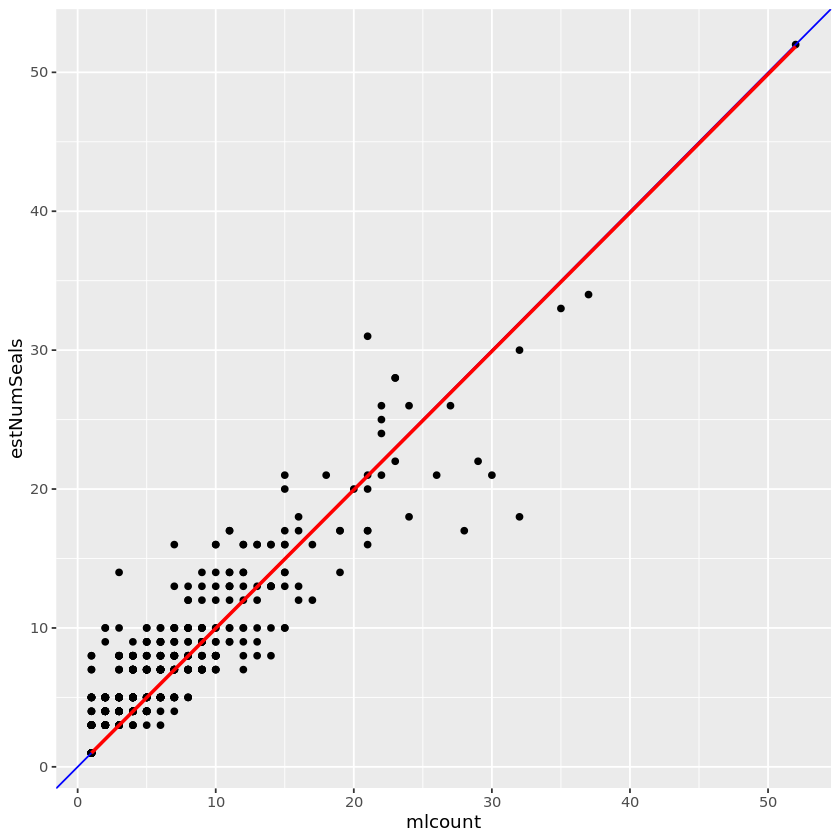

In [192]:
estByRegionQ<-as.data.frame(counts[,c("region","lclNumSeals","estNumSeals","uclNumSeals")] %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionQ<-rbind(estByRegionQ,data.frame(region="Total",lclNumSeals=round(sum(countByQ$lclNumSeals)),estNumSeals=round(sum(countByQ$estNumSeals)),uclNumSeals=round(sum(countByQ$uclNumSeals))))
print(estByRegionQ)
ggplot(subset(counts,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")
summary(counts$estNumSeals)


## Removing the hour effect
The above graph of counts by hour shows a well-known fact: seals have a daily pattern of dives that results in more seals in the water (thus not detectable in the satellite images) at certain times of the day, and more seals on ice at other times. We accounted for this effect when we constructed correction models that adjust the satellite estimates above to the real count on the ground. However, these models were fitted with a different set of data. In fact, the dataset we used did not include all hours of the day (as the one for the full continent does).  
  
So here we fit a model for the hour effect, so that we can then remove this effect from the data, and then use our ground-count-correction models setting the hour effect to 0 (because we already adjusted for it). How do we do that?
  
